In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import os
%load_ext autoreload
%autoreload 2

In [2]:
'version:', tf.__version__ 

('version:', '2.0.0')

In [3]:
'gpu available:', tf.test.is_gpu_available()

('gpu available:', False)

# Read Data
- all datasets are datetime sorted

In [4]:
# path = 'C:/Users/robin.opdam/Google Drive/Thesis (Msc)/Thesis_shared_files/'
path = '/Users/Robin/Google Drive/Thesis (Msc)/Thesis_shared_files/'
# path = '../' # Paperspace

## Amazon Fashion 

In [5]:
# file_name = 'Amazon_full' 
# file_name = 'Amazon_05_users' 
# file_name = 'Amazon_01_users'

## MovieLens 

In [6]:
# data_path = 'datasets/' # Paperspace
data_path = 'Data/ML/'
# data_path = 'data/ML/'
# file_name = 'ML_full' 
# file_name = 'ML_05_users'
file_name = 'ML_01_users'

In [7]:
df = pd.read_pickle(path + data_path + file_name)
df['item_id'] = df.item.astype('category').cat.codes
df['user_id'] = df.user.astype('category').cat.codes
df.head()

,user,item,rating,datetime,item_id,user_id
18590190,120461,2501,5.0,2000-04-25 02:29:35,2372,11959
18590032,120461,252,4.0,2000-04-25 02:29:35,246,11959
18590159,120461,2069,4.0,2000-04-25 02:29:35,1946,11959
18590048,120461,440,4.0,2000-04-25 02:29:35,431,11959
18590145,120461,1959,4.0,2000-04-25 02:29:35,1836,11959


# Data Prep

## Init

In [8]:
total_items = len(df.item_id.unique())

In [9]:
res_ext = file_name[:2]
all_models = pd.read_pickle(path + 'results/' + res_ext + '/all_models')

### New Model?

In [17]:
new_model_id = str(int(all_models.model_id.max()[0]) + 1) + '_' + res_ext

In [9]:
res_ext = file_name[:2]
new_model_id = str(0) + '_' + res_ext

In [113]:
params = {
'model_id':new_model_id,
'train_time':0,
'epochs':0,
'BATCH_SIZE':32,
'learning_rate':0.1,
'delta':0.2,             # Diversity Bias
'max_seq_len':30,        # Max length of sequence71=median

'val_perc':0.1,          # Percentage of users from df in val and test set
'test_perc':0.1, 
'n_items_val':0,        # Number of last (chronologically) items in val and test set
'n_items_test':1,

'pad_value':total_items, # Pad with total_items+1 => masked => still use item 0
'shift_targets_by':1     
}

In [114]:
BATCH_SIZE = params['BATCH_SIZE']
learning_rate = params['learning_rate']
delta = params['delta']
max_seq_len = params['max_seq_len']

val_perc = params['val_perc']
test_perc = params['test_perc']
n_items_val = params['n_items_val']
n_items_test = params['n_items_test']

pad_value = params['pad_value']
shift_targets_by = params['shift_targets_by'] 

In [115]:
n_items_val

0

## Train Test Split

In [98]:
from Data_prep import train_val_test_split

# Train Test Val Split
data_split = train_val_test_split(df, val_perc, test_perc, n_items_val, n_items_test, seqs=True)

train_set, val_set, val_left_out_items, test_set, test_left_out_items = data_split

## Create Datasets
- Can make train_val_test_split and create_seq_batch_dataset one step

In [99]:
from Data_prep import create_seq_batch_dataset
    
#Train Set
train_dataset = create_seq_batch_dataset(df=train_set, 
                                         shift=shift_targets_by, 
                                         max_seq_len=max_seq_len, 
                                         pad_value=pad_value, 
                                         batch_size=BATCH_SIZE, 
                                         stats=False,
                                         drop_remainder=True)

#Val Set
val_dataset = create_seq_batch_dataset(df=val_set, 
                                       shift=shift_targets_by, 
                                       max_seq_len=max_seq_len, 
                                       pad_value=pad_value, 
                                       batch_size=BATCH_SIZE, 
                                       stats=False,
                                       drop_remainder=True)

#Test Set
test_dataset = create_seq_batch_dataset(df=test_set, 
                                       shift=shift_targets_by, 
                                       max_seq_len=max_seq_len, 
                                       pad_value=pad_value, 
                                       batch_size=BATCH_SIZE, 
                                       stats=False,
                                       drop_remainder=True)

---
# LSTM Model
Collaborative Filtering with Recurrent Neural Networks
- paper: https://arxiv.org/pdf/1608.07400.pdf
- code: https://github.com/rdevooght/sequence-based-recommendations (in Theano)

## Build Model

In [157]:
embedding_dim = 100
rnn_units = 20

In [158]:
from Models import build_LSTM_model
model = build_LSTM_model(total_items = total_items, # +1 because padding is total_items+1
                         embedding_dim = embedding_dim,
                         mask_value = pad_value,
                         rnn_units = rnn_units,
                         batch_size = BATCH_SIZE)

## Add Custom Metric=Recall and Loss=Diversity Bias Loss

In [159]:
from Evaluation import recall_metric, diversity_bias_loss, create_diversity_bias

In [160]:
# Added 1 to length of precomputation of diveristy bias? Only on local machine
diversity_bias = create_diversity_bias(train_set, total_items+1, delta)

In [161]:
optimizer=tf.keras.optimizers.Adagrad(lr=learning_rate)
loss=diversity_bias_loss(db=diversity_bias, total_items=total_items)
metrics=[recall_metric(total_items=total_items)]

model.compile(optimizer=optimizer,
              loss=loss, 
              metrics=metrics)

## Summmary

In [162]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (32, None, 100)           2738800   
_________________________________________________________________
masking_5 (Masking)          (32, None, 100)           0         
_________________________________________________________________
lstm_5 (LSTM)                (32, None, 20)            9680      
_________________________________________________________________
dense_5 (Dense)              (32, None, 27387)         575127    
Total params: 3,323,607
Trainable params: 3,323,607
Non-trainable params: 0
_________________________________________________________________


---
# Train Model

## Configure Callbacks

In [163]:
ext = '_' + file_name[:2] #ML or Am
directory = './ckpts/ckpts' 
# directory = '../ckpts/ckpts'

# Directory where the checkpoints will be saved
checkpoint_dir = directory + '_' + str(params['model_id'])

# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

In [172]:
from Helpers import TimingCallback

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_prefix,    
                                                         monitor = 'val_recall',    
                                                         mode = 'max',    
                                                         save_best_only = True,
                                                         save_weights_only = True)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor = 'recall',
                                                           min_delta = 0.0001,
                                                           mode = 'max',
                                                           patience = 15)
    

timing_callback = TimingCallback()

callbacks = [checkpoint_callback, early_stopping_callback, timing_callback]

## Fit Model

In [173]:
epochs = 2
print('#Batches:', tf.data.experimental.cardinality(train_dataset).numpy())
print('Batch size:', BATCH_SIZE)

#Batches: 406
Batch size: 32


In [174]:
train_dataset.range(10)

<RangeDataset shapes: (), types: tf.int64>

In [ ]:
print('Fitting LSTM with max sequence length:', str(max_seq_len))
history = model.fit(x = train_dataset, 
                    validation_data=val_dataset, 
                    epochs=epochs,
                    callbacks=callbacks)

Fitting LSTM with max sequence length: 30
Epoch 1/2
      1/Unknown - 0s 8ms/stepWARNING:tensorflow:Can save best model only with val_recall available, skipping.
      1/Unknown - 0s 9ms/step

# TODO

In [127]:
from Models import store_LSTM_model
store_path = path + 'results/CFRNN/' + res_ext + '/all_models'
train_time = 20# np.sum(timing_callback.logs)
all_models = store_LSTM_model(store_path, params, his.copy(), train_time, eval_metrics, store=False)
all_models

NameError: name 'his' is not defined

## Plot Training Loss, Metrics

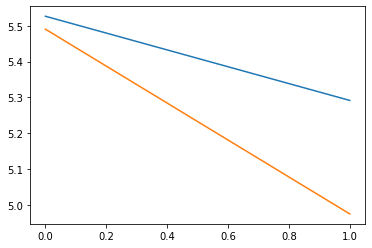

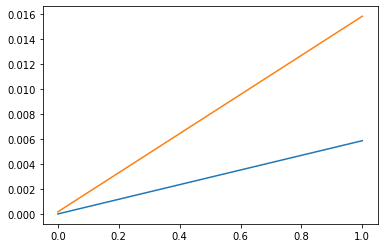

In [59]:
plt.plot(results['loss'])
plt.plot(results['val_loss'])
plt.show()
plt.plot(results['recall'])
plt.plot(results['val_recall'])
plt.show()

---
## Continue training from checkpoint

### Load Weights

In [396]:
from Models import build_LSTM_model
model = build_LSTM_model(total_items = total_items + 1, # +1 because padding is total_items+1
                         embedding_dim = embedding_dim,
                         mask_value = pad_value,
                         rnn_units = rnn_units,
                         batch_size = BATCH_SIZE)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

### Compile

In [ ]:
from Evaluation import recall_metric, diversity_bias_loss, create_diversity_bias
diversity_bias = create_diversity_bias(train_set, total_items+1, delta)

optimizer=tf.keras.optimizers.Adagrad(lr=learning_rate)
loss=diversity_bias_loss(db=diversity_bias, total_items=total_items)
metrics=[recall_metric(total_items=total_items)]

model.compile(optimizer=optimizer,
              loss=loss, 
              metrics=metrics)

In [397]:
initial_epoch = 100
total_epochs = 200

### Continue Training

In [ ]:
history = model.fit(dataset, 
                    validation_data=val_dataset, 
                    epochs=total_epochs, 
                    callbacks=[checkpoint_callback, early_stopping_callback], 
                    initial_epoch=initial_epoch)

---
# Predict Sequences

## Restore Latest Checkpoints
- TODO: include partial when loading weights

In [154]:
from Models import build_LSTM_model
model = build_LSTM_model(total_items = total_items + 1, # +1 because padding is total_items+1
                         embedding_dim = embedding_dim,
                         mask_value = pad_value,
                         rnn_units = rnn_units,
                         batch_size = BATCH_SIZE,
                         return_sequences=True)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([1, None]))

ValueError: Shapes (27389, 100) and (27388, 100) are incompatible

In [106]:
tf.train.latest_checkpoint(checkpoint_dir)

'./ckpts_0_ML/ckpt'

In [40]:
def get_predictions(model, test_set, test_left_out_items, rank_at):
    """
    Uses a Keras model with batch size set to 1 to predict the rest of the sequences from the train_set per user.
    Finally creates predictions_df where each row represents user, a list pred_items_ranked and a list containing true_ids
    from the test_set
    :param model: Keras RNN model with batch size set to 1
    :param train_set: pandas df containing user_id, item_id sorted on datetime per user
    :param test_set: pandas df containing: user_id, last item_id(s) per user
    :param rank_at: maximum of top ranked items per user
    :param temp: temperature, 1 means no deviation from model prediction
    :return: pandas df where each row represents a user, the columns represent: pred_items_ranked at rank_at,
             true_id extracted from test_set
    """
    test_user_sequences = train_set[train_set.user_id.isin(test_set.user_id.unique())].groupby('user_id')['item_id'].apply(list)
    user_items = np.array(test_set.groupby('user_id')['item_id'].apply(list))
    users = test_user_sequences.index 
    all_predictions = []
    all_true_items = []

    for true_items, user_sequence in zip(user_items, test_user_sequences):
        predictions = []
        all_true_items.append(list(np.array(true_items)))
        for i in range(rank_at):
            pred_item_id = model.predict_classes(np.array([user_sequence,]), batch_size=1)
            user_sequence.append(pred_item_id)
            predictions.append(pred_item_id)

        all_predictions.append(predictions)

    predictions_df = pd.DataFrame(list(zip(users, all_predictions, all_true_items)),
                              columns=['user', 'pred_items_ranked', 'true_id'])


    return predictions_df

In [149]:
def get_predictions(model, test_set, test_left_out_items, rank_at):
    """
    Uses a Keras model with batch size set to 1 to predict the rest of the sequences from the train_set per user.
    Finally creates predictions_df where each row represents user, a list pred_items_ranked and a list containing true_ids
    from the test_set
    :param model: Keras RNN model with batch size set to 1
    :param train_set: pandas df containing user_id, item_id sorted on datetime per user
    :param test_set: pandas df containing: user_id, last item_id(s) per user
    :param rank_at: maximum of top ranked items per user
    :param temp: temperature, 1 means no deviation from model prediction
    :return: pandas df where each row represents a user, the columns represent: pred_items_ranked at rank_at,
             true_id extracted from test_set
    """
    user_sequences = test_set.groupby('user_id')['item_id'].apply(list)
    user_true_items = test_left_out_items.groupby('user_id')['item_id'].apply(list)
    all_predictions = []
    all_true_items = []

    for user, true_items in user_items.items():
        predictions = []
        user_seq = user_sequences[user]
        for i in range(rank_at):
            pred_item_id = model.predict_classes(np.array([user_seq,]), batch_size=1)
            user_seq.append(pred_item_id)
            predictions.append(pred_item_id)

        all_true_items.append(true_items)
        all_predictions.append(predictions)

    predictions_df = pd.DataFrame(list(zip(users, all_predictions, all_true_items)),
                              columns=['user', 'pred_items_ranked', 'true_id'])

    return predictions_df

In [150]:
rank_at = 20
preds_df = get_predictions(model, test_set, test_left_out_items, rank_at)

ValueError: The `batch_size` argument value 1 is incompatible with the specified batch size of your Input Layer: 32

In [135]:
user_items = test_left_out_items.groupby('user_id')['item_id'].apply(list)

In [138]:
type(user_items)

pandas.core.series.Series

In [140]:
test_items = test_set.groupby('user_id')['item_id'].apply(list)

In [142]:
test_items[2]

[1240,
 1150,
 3851,
 1149,
 1499,
 15119,
 5260,
 1091,
 4338,
 2147,
 4516,
 11029,
 4861,
 1595,
 1171,
 491,
 4807,
 12781,
 14766,
 9528,
 6452,
 9416,
 1038,
 369,
 2850,
 5682,
 10723,
 2670,
 2409,
 2000,
 3112,
 3501,
 401,
 3037]

In [141]:
for u, items in test_items.items():
    print(u, items)

2 [1240, 1150, 3851, 1149, 1499, 15119, 5260, 1091, 4338, 2147, 4516, 11029, 4861, 1595, 1171, 491, 4807, 12781, 14766, 9528, 6452, 9416, 1038, 369, 2850, 5682, 10723, 2670, 2409, 2000, 3112, 3501, 401, 3037]
9 [753, 31, 630, 24, 137, 16, 708, 35, 4, 595, 254, 684, 635, 51, 57, 716, 822, 751, 802, 1161, 1338, 828, 625, 629, 683, 650, 1136, 819, 1336, 738, 848, 25, 84, 773, 81, 1304, 1076, 739, 754, 77, 1183, 1370, 690, 1419, 4243, 1301, 1312, 1021, 1305, 1403, 821, 1344, 1401, 1311, 578, 532, 518, 284, 958, 208]
36 [580, 578, 289, 372, 107, 348, 577, 448, 49, 471, 148, 630, 369, 20, 753, 465, 576, 46, 356, 247, 998, 759, 711, 137, 15, 491, 349, 499, 583, 575, 775, 445, 585, 543, 360, 582, 431, 574, 93, 285, 530, 17, 359, 989, 584, 488, 203, 342, 345, 616, 153, 47, 541, 756, 536, 233, 991, 306, 984, 994, 987, 542, 196, 540, 336, 225, 425, 180, 331, 18, 401, 411, 38, 155]
41 [2963, 1231, 2208, 1340, 2509, 1150, 2629, 2724, 2869, 2860, 2943, 2859, 2497, 1201, 1535, 896, 1209, 888, 3184, 1

7606 [1052, 1322, 1786, 2963, 69, 334, 368, 2895, 462, 1882, 2326, 250, 1286, 246, 1348, 2069, 1022, 699, 2037, 1844, 311, 49, 518, 878, 870, 5796]
7608 [581, 542, 107, 991, 3210, 1165, 3123, 465, 1150, 1172, 1905, 254, 2441, 2811, 2813, 1528, 448, 1252, 1152, 1877, 998, 1319, 1149, 1224, 1189, 2399, 2070, 1499, 1161, 3533, 3112, 3472, 545, 2780, 1171, 1173, 2559, 2966, 1789, 2043, 2361, 471, 1446, 20, 1493, 5, 1665, 1315, 369, 1676, 580, 2328, 1010, 1991, 1935, 1082, 2854, 708, 1544, 1351, 2069, 2299, 341, 2152, 2848, 1059, 1321, 2509, 2265, 2969, 1878, 2497, 1628, 753, 2225, 372, 1323, 508, 2944, 2347, 285, 345, 3534, 3471, 1009, 1879, 1317, 1526, 2242, 3570, 2590, 1794, 1753, 3287, 1303, 1589, 309, 3069, 2883, 498, 1714, 2692, 457, 93, 321, 2602, 3527, 2248, 41, 1594, 476, 853, 2277, 771, 2002, 1336, 1918, 2511, 1689, 2682, 1467, 1318, 3594, 1324, 1148, 1156, 1251, 885, 1208, 3320, 1240, 2013, 0, 2015, 2896, 2168, 2671, 1219, 3264, 1021, 1225, 2655, 2662, 1091, 1845, 2724, 2782, 338

12700 [311, 518, 2441, 6880, 2823, 13358, 4805, 254, 1150, 828, 5734, 2202, 581, 9, 1047, 286, 11411, 9528, 1148, 49, 12778, 10757, 3413, 5246, 3846, 3835, 3723, 4807, 5179, 6125, 532, 1165, 12191, 15607, 1091, 12423, 108, 11662, 577, 6608, 356, 348, 10108, 289, 31, 13540, 14881, 13285, 13708, 1176, 1236, 1156, 10474, 17412, 11170, 6289, 5150, 4775, 7149, 3801, 1189, 372, 11935, 1048, 9030, 46, 583, 14171, 14115, 9037, 145, 2338, 22250, 19195, 7629, 18017, 15245, 1151, 107, 1, 595, 2142, 499, 18019]
12704 [2823, 4805, 5734, 6880, 3413, 4127, 11411, 6289, 6136, 4698, 5246, 3820, 7087, 4775, 6608, 4807, 13358, 7149, 3773, 11489, 7560, 5796, 12778, 10757, 4068, 11849, 7748, 12423, 9670, 4822, 3547, 12287, 5468, 15607, 3842, 9037, 6287, 4533, 7629, 10577, 11208, 9512, 4628, 13672, 13540, 13052, 8032, 4453, 7561, 8066, 9416, 8040, 10222, 13157, 11951, 3140, 8055, 6048, 9764, 16410, 15573, 16214, 9188, 19327, 9192, 7674, 11734, 4702, 5026, 14098, 12337, 6315, 15317, 10903, 6494, 10305, 17257

In [139]:
for u, items in user_items.items():
    print(u, items)

2 [2895]
9 [1146]
36 [310]
41 [181]
46 [18701]
47 [13953]
68 [9917]
72 [1165]
77 [11411]
78 [755]
83 [9141]
86 [9536]
95 [1149]
109 [1185]
140 [9996]
146 [4533]
150 [2268]
164 [1035]
218 [1]
225 [684]
230 [587]
237 [703]
246 [11033]
259 [2386]
264 [15607]
267 [737]
277 [20]
285 [4699]
293 [2949]
304 [1886]
310 [2011]
316 [6871]
317 [1159]
319 [12939]
332 [11951]
356 [1637]
388 [4142]
398 [723]
407 [3339]
408 [11411]
425 [797]
442 [475]
458 [81]
459 [6681]
465 [165]
478 [5734]
506 [9946]
510 [12554]
516 [364]
524 [250]
525 [2933]
528 [7865]
538 [10333]
547 [1161]
599 [2859]
602 [289]
637 [714]
659 [613]
660 [11688]
666 [6665]
669 [1499]
670 [8326]
677 [199]
689 [629]
691 [14097]
694 [252]
709 [31]
730 [24]
743 [14757]
761 [26832]
762 [6236]
764 [603]
765 [1170]
767 [3293]
771 [11490]
776 [4454]
780 [10391]
789 [693]
816 [2938]
822 [18028]
827 [255]
830 [753]
831 [110]
841 [14369]
855 [1046]
860 [870]
862 [2658]
866 [758]
893 [583]
911 [1503]
915 [17257]
920 [1395]
932 [11494]
958 [5215]

11527 [1313]
11532 [49]
11545 [880]
11548 [4096]
11554 [12987]
11562 [25508]
11569 [2658]
11573 [1905]
11576 [311]
11587 [703]
11591 [11428]
11594 [6844]
11596 [12201]
11601 [1250]
11602 [3886]
11603 [2823]
11625 [16046]
11642 [5953]
11647 [10991]
11654 [1394]
11671 [1271]
11699 [3131]
11707 [17685]
11715 [708]
11716 [465]
11747 [375]
11752 [3322]
11756 [7427]
11759 [431]
11788 [3037]
11795 [1146]
11808 [4068]
11812 [515]
11826 [1173]
11835 [7181]
11838 [1800]
11847 [18361]
11861 [981]
11862 [5656]
11872 [583]
11876 [6141]
11881 [485]
11884 [1554]
11885 [2036]
11890 [8949]
11897 [585]
11901 [4807]
11907 [7166]
11917 [757]
11919 [656]
11931 [3]
11956 [7748]
11994 [595]
12003 [1422]
12009 [532]
12011 [281]
12027 [12210]
12031 [289]
12040 [1132]
12058 [3565]
12060 [950]
12069 [575]
12096 [2930]
12101 [2441]
12115 [4040]
12127 [337]
12132 [1189]
12137 [2400]
12142 [9512]
12171 [10108]
12183 [9741]
12205 [848]
12215 [3413]
12223 [3536]
12240 [356]
12261 [19733]
12264 [7468]
12274 [3394]
122

In [32]:
test_set_u_i = test_set.groupby('user_id')['item_id'].apply(list)
test_X = []
test_y = []
all_predictions = []
for user_items in test_set_u_i:
    test_X.append(user_items[-200:-1])
    test_y.append(user_items[-1:])

for i, seq in enumerate(test_X): 
    seq = seq.copy()
    predictions = []
    for i in range(20):
        pred_item_id = model.predict_classes(np.array([seq,]), batch_size=1)[0]
        seq.append(pred_item_id)
        predictions.append(pred_item_id)
    all_predictions.append(predictions)
    
predictions_df = pd.DataFrame(list(zip(test_set.user_id.unique(), all_predictions, test_y)),
                              columns=['user', 'pred_items_ranked', 'true_id'])

In [ ]:
# for p in predictions_df['pred_items_ranked']:
#     for i in p:
#         if i != 348:
#             print(i)

In [33]:
train_set.groupby('item_id')['user_id'].count().sort_values(ascending=False)[:20]

item_id
311     7762
348     7684
289     7468
581     6946
2441    6855
254     6457
471     6022
518     5733
107     5521
2823    5510
577     5400
1148    5391
0       5363
4805    5274
49      5177
1150    5133
1161    5127
2724    5109
828     4936
5734    4877
Name: user_id, dtype: int64

In [34]:
predictions_df

,user,pred_items_ranked,true_id
0,9430,"[289, 289, 581, 581, 581, 581, 581, 581, 311, ...",[11411]
1,15350,"[348, 348, 348, 289, 311, 289, 311, 311, 145, ...",[13707]
2,9516,"[10968, 10968, 10968, 10968, 10968, 10968, 109...",[17257]
3,7237,"[348, 348, 348, 348, 348, 348, 348, 348, 348, ...",[348]
4,13653,"[254, 254, 254, 254, 254, 254, 254, 254, 254, ...",[532]
...,...,...,...
495,3602,"[753, 753, 753, 630, 630, 630, 630, 630, 630, ...",[1131]
496,9515,"[761, 761, 761, 761, 761, 761, 761, 761, 761, ...",[336]
497,11961,"[828, 828, 828, 254, 254, 254, 828, 254, 254, ...",[1800]
498,14898,"[289, 289, 581, 581, 581, 581, 581, 581, 581, ...",[5098]


## Create Predictions
- **TODO: Can keep batches of 64 for evaluation => faster**

Using train_set sequences to predict test_set / val_set item(s)

In [373]:
from Evaluation import get_predictions

In [374]:
file_name

'ML_01_users'

### Val Set Predictions

In [33]:
rank_at = 20
preds_val = get_predictions(model, train_set, val_set, rank_at)
preds_val.to_pickle('../results/preds_val_CFRNN_vsl_100_' + file_name + '_lr' + str(learning_rate))

### Fixed

In [33]:
rank_at = 20
preds_val = get_predictions(model, train_set, val_set, rank_at)
preds_val.to_pickle('../results/preds_val_CFRNN_fixed_100_' + str(max_seq_len) + '_' + file_name + '_lr' + str(learning_rate))

### Test Set Predictions

In [34]:
rank_at = 20
preds_test = get_predictions(model, train_set, test_set, rank_at)
preds_test.to_pickle('../results/preds_test_CFRNN_vsl_100_' + file_name + '_lr' + str(learning_rate))

### Fixed

In [34]:
rank_at = 20
preds_test = get_predictions(model, train_set, test_set, rank_at)
preds_test.to_pickle('../results/preds_test_CFRNN_fixed_100_' + str(max_seq_len) + '_' + file_name + '_lr' + str(learning_rate))

#### Read Predictions

In [55]:
# predictions = pd.read_pickle('CFRNN_res_200_ML_01_users')

---
# Evaluate

In [ ]:
preds_df

In [ ]:
from Evaluation import get_metrics

In [ ]:
metrics_test_set_vsl = get_metrics(preds_df, 5, 20)
metrics_test_set_vsl

### Val Set Metrics

In [36]:
metrics_val_set_vsl = get_metrics(preds_val, 5, 20)
metrics_val_set_vsl

Obtaining metrics time: 1.12


,rank_at,hitcounts,recall,precision
0,1,1,0.000601,0.000601
1,5,8,0.004808,0.000962
2,10,15,0.009014,0.000901
3,15,21,0.012620,0.000841
4,20,27,0.016226,0.000811


In [37]:
metrics_val_set_vsl.to_pickle('../results/metrics_val_CFRNN_fixed_' + str(max_seq_len) + '_' + file_name + '_lr' + str(learning_rate))

In [37]:
metrics_val_set_vsl.to_pickle('../results/metrics_val_CFRNN_vsl_' + file_name + '_lr' + str(learning_rate))

### Test Set Metrics

In [38]:
metrics_test_set_vsl = get_metrics(preds_test, 5, 20)
metrics_test_set_vsl

Obtaining metrics time: 1.13


,rank_at,hitcounts,recall,precision
0,1,1,0.000601,0.000601
1,5,4,0.002404,0.000481
2,10,8,0.004808,0.000481
3,15,12,0.007212,0.000481
4,20,19,0.011418,0.000571


In [39]:
metrics_test_set_vsl.to_pickle('../results/metrics_test_CFRNN_fixed_' + str(max_seq_len) + '_' + file_name + '_lr' + str(learning_rate))

In [39]:
metrics_test_set_vsl.to_pickle('../results/metrics_test_CFRNN_vsl_' + file_name + '_lr' + str(learning_rate))

# Appendix

In [ ]:
# oh_input = tf.keras.backend.one_hot(padded, n_items)
# e = tf.keras.layers.Embedding(n_items, 100, input_length=max_l)

In [ ]:
# One hot encoded input
# sequences_data_x = tf.data.Dataset.from_tensor_slices(tf.keras.backend.one_hot(padded_sequences_x, n_items)) 
# sequences_data_y = tf.data.Dataset.from_tensor_slices(tf.keras.backend.one_hot(padded_sequences_y, n_items)) 

In [ ]:
# max_seq_len = 30
# min_seq_len = 10
# shift_targets_by = 1

# from Data_prep import get_x_y_sequences, min_padding
# vsl = True # Set for training later

# # Train Set
# user_sequences_x, user_sequences_y, user_order = get_x_y_sequences(train_set, shift_targets_by)
# padded_sequences_x = min_padding(user_sequences_x, BATCH_SIZE, min_seq_len, max_seq_len)
# padded_sequences_y = min_padding(user_sequences_y, BATCH_SIZE, min_seq_len, max_seq_len)

# # Val Set 
# user_sequences_val_x, user_sequences_val_y, user_order = get_x_y_sequences(val_set, shift_targets_by, stats=False)
# padded_sequences_val_x = min_padding(user_sequences_val_x, BATCH_SIZE, min_seq_len, max_seq_len)
# padded_sequences_val_y = min_padding(user_sequences_val_y, BATCH_SIZE, min_seq_len, max_seq_len)